In [ ]:
#!pip install pandas numpy nltk seaborn matplotlib scikit-learn transformers torch datasets contradictions

Defaulting to user installation because normal site-packages is not writeable


In [57]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import (AutoTokenizer, DataCollatorWithPadding,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from datasets import Dataset
import torch
import nltk

In [58]:
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # If you need stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     /home/basantiroomie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/basantiroomie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
df = pd.read_csv('dataset/cleaned_data_with_word_count.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataset
df.head()

,category,sub_category,crimeaditionalinfo,word_count
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...,46
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...,45
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...,40
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...,98
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...,37


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82018 entries, 0 to 82017
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            82018 non-null  object
 1   sub_category        82018 non-null  object
 2   crimeaditionalinfo  82018 non-null  object
 3   word_count          82018 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.5+ MB


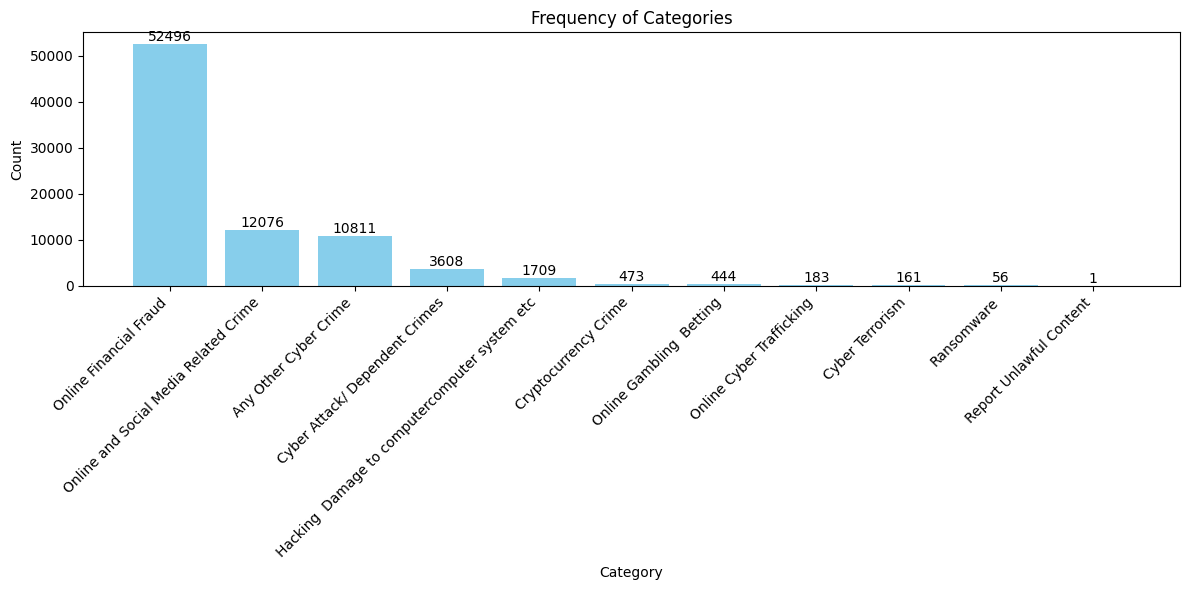

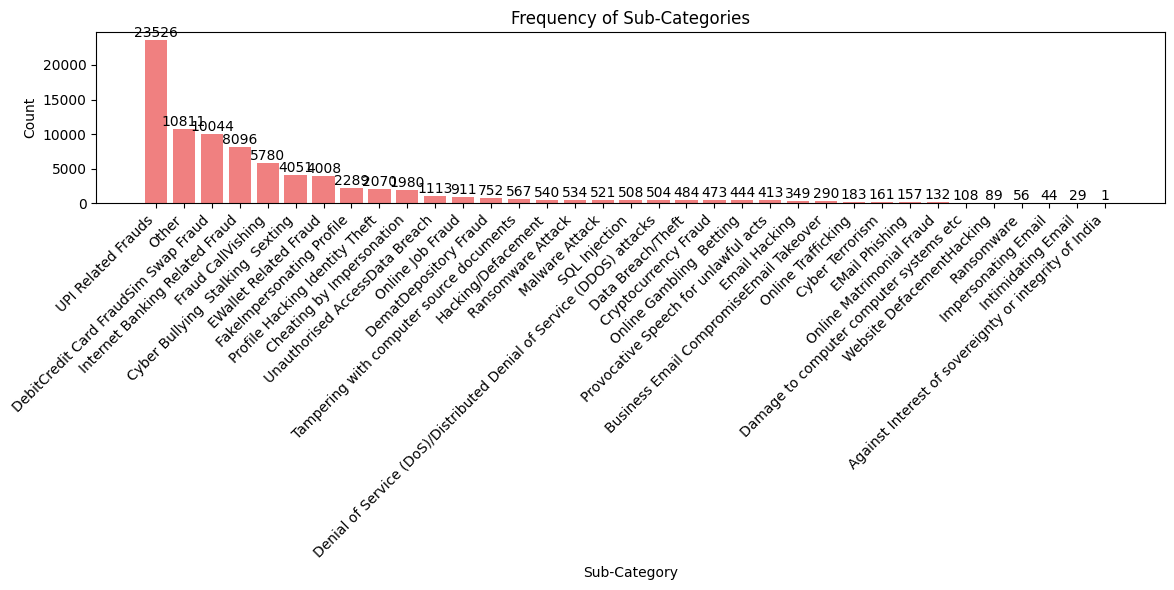

In [61]:
# Step 1: Count the occurrences of each category and sub_category
category_count = df['category'].value_counts().reset_index()
category_count.columns = ['Category', 'Count']

sub_category_count = df['sub_category'].value_counts().reset_index()
sub_category_count.columns = ['Sub-Category', 'Count']

# Step 2: Create a bar plot for the counts of categories
plt.figure(figsize=(12, 6))
plt.bar(category_count['Category'], category_count['Count'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Frequency of Categories')
plt.xticks(rotation=45, ha='right')
for i in range(len(category_count)):
    plt.annotate(f'{category_count["Count"].iloc[i]}', 
                 xy=(category_count['Category'].iloc[i], category_count['Count'].iloc[i] + 0.5),
                 ha='center', va='bottom', color='black')
plt.tight_layout()
plt.show()

# Step 3: Create a bar plot for the counts of sub-categories
plt.figure(figsize=(12, 6))
plt.bar(sub_category_count['Sub-Category'], sub_category_count['Count'], color='lightcoral')
plt.xlabel('Sub-Category')
plt.ylabel('Count')
plt.title('Frequency of Sub-Categories')
plt.xticks(rotation=45, ha='right')
for i in range(len(sub_category_count)):
    plt.annotate(f'{sub_category_count["Count"].iloc[i]}', 
                 xy=(sub_category_count['Sub-Category'].iloc[i], sub_category_count['Count'].iloc[i] + 0.5),
                 ha='center', va='bottom', color='black')
plt.tight_layout()
plt.show()


In [62]:
# Preprocessing function to remove unwanted characters
def remove_punctuations(text):
    text = re.sub(r'[\\-]', ' ', text)
    text = re.sub(r'[,.?;:\'(){}!|0-9]', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Removes anything that's not a word or space
    return text

# Apply preprocessing to the text
df['crimeaditionalinfo'] = df['crimeaditionalinfo'].apply(remove_punctuations)

# Display the cleaned dataset
df.head()


,category,sub_category,crimeaditionalinfo,word_count
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...,46
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...,45
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...,40
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...,98
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...,37


In [63]:
import contractions

def preprocess_text(text):
    # Step 1: Expand contractions
    text = contractions.fix(text)
    
    # Step 3: Remove short words (length <= 2)
    text = ' '.join([word for word in text.split() if len(word) > 2])
    
    return text

# Apply the preprocessing function to the 'crimeaditionalinfo' column
df['crimeaditionalinfo'] = df['crimeaditionalinfo'].apply(preprocess_text)

df.head()


,category,sub_category,crimeaditionalinfo,word_count
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,had continue received random calls and abusive...,46
1,Online Financial Fraud,Fraud CallVishing,The above fraudster continuously messaging and...,45
2,Online Gambling Betting,Online Gambling Betting,acting like police and demanding for money add...,40
3,Online and Social Media Related Crime,Online Job Fraud,apna Job have applied for job interview for te...,98
4,Online Financial Fraud,Fraud CallVishing,received call from lady stating that she will ...,37


In [66]:
# English stopwords
stopw = stopwords.words('english')

# Function to remove stopwords
def remove_stopwords(text):
    # Convert to lowercase for consistency
    text = text.lower()
    
    # Tokenize the text and remove stopwords
    clean_text = [word for word in text.split() if word not in stopw]
    
    return ' '.join(clean_text)

# Assuming 'df' is the DataFrame you're working with
df['crimeaditionalinfo'] = df['crimeaditionalinfo'].apply(remove_stopwords)

df.head()


,category,sub_category,crimeaditionalinfo,word_count
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,continue received random calls abusive message...,46
1,Online Financial Fraud,Fraud CallVishing,fraudster continuously messaging asking pay mo...,45
2,Online Gambling Betting,Online Gambling Betting,acting like police demanding money adding sect...,40
3,Online and Social Media Related Crime,Online Job Fraud,apna job applied job interview telecalling res...,98
4,Online Financial Fraud,Fraud CallVishing,received call lady stating send new phone vivo...,37


In [ ]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to apply stemming
def apply_stemming(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

df['crimeaditionalinfo'] = df['crimeaditionalinfo'].apply(apply_stemming)

def apply_lemmatization(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

#df['crimeaditionalinfo'] = df['crimeaditionalinfo'].apply(apply_lemmatization)

df.head()


,category,sub_category,crimeaditionalinfo,word_count
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,continu receiv random call abus messag whatsap...,46
1,Online Financial Fraud,Fraud CallVishing,fraudster continu messag ask pay money send fa...,45
2,Online Gambling Betting,Online Gambling Betting,act like polic demand money ad section text me...,40
3,Online and Social Media Related Crime,Online Job Fraud,apna job appli job interview telecal resourc m...,98
4,Online Financial Fraud,Fraud CallVishing,receiv call ladi state send new phone vivo rec...,37


In [68]:
# Remove leading/trailing whitespace and replace multiple spaces with a single space
df['crimeaditionalinfo'] = df['crimeaditionalinfo'].apply(lambda x: ' '.join(x.split()))
df.head()

,category,sub_category,crimeaditionalinfo,word_count
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,continu receiv random call abus messag whatsap...,46
1,Online Financial Fraud,Fraud CallVishing,fraudster continu messag ask pay money send fa...,45
2,Online Gambling Betting,Online Gambling Betting,act like polic demand money ad section text me...,40
3,Online and Social Media Related Crime,Online Job Fraud,apna job appli job interview telecal resourc m...,98
4,Online Financial Fraud,Fraud CallVishing,receiv call ladi state send new phone vivo rec...,37


In [73]:
import pandas as pd
import os

output_path = 'dataset/cleaned_data_train.csv'

# Ensure that the path exists
if not os.path.exists('dataset'):
    os.makedirs('dataset')  # Create the 'dataset' directory if it doesn't exist

# Now save the file
df.to_csv(output_path, index=False)

print(f"Cleaned data with word count saved to '{output_path}'.")

Cleaned data with word count saved to 'dataset/cleaned_data_train.csv'.


In [ ]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing and dataset pipeline functions
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=512)

def create_label_mapping(dataframe):
    unique_labels = dataframe['target'].unique()
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    return label_mapping

def pipeline(dataframe, label_mapping):
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)

    # Map the string labels to integers
    tokenized_ds = tokenized_ds.map(lambda x: {'labels': label_mapping[x['target']]})
    tokenized_ds = tokenized_ds.remove_columns('text')  # Remove text column if not needed
    return tokenized_ds

In [ ]:
label_mapping = create_label_mapping(train_df)
# Print the label mapping
print("Label Mapping:")
for label, idx in label_mapping.items():
    print(f"{idx}: {label}")

In [ ]:
tokenized_train = pipeline(train_df, label_mapping)
tokenized_test = pipeline(test_df, label_mapping)
# Create label mappings (label2id and id2label)
label2id = label_mapping  # label name to id
id2label = {v: k for k, v in label_mapping.items()}  # id to label name
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))
model.to(device)
# Add label mappings to the model's config
model.config.label2id = label2id
model.config.id2label = id2label

In [ ]:
# Set up training arguments with early stopping
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy='epoch',
    optim='adamw_torch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    num_train_epochs=3,  # Total number of epochs
    weight_decay=0.01,
    evaluation_strategy="epoch",  # Evaluate after each epoch
    load_best_model_at_end=True,  # Load the best model when finished training
    metric_for_best_model="eval_loss",  # Metric to compare to determine the best model
    greater_is_better=False,  # We want the eval loss to decrease
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=500,  # Log every 500 steps
    eval_steps=500,  # Evaluate every 500 steps
    save_total_limit=1,  # Only save the best model
)

# Define early stopping criteria
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Stop training if no improvement for 3 epochs
    early_stopping_threshold=0.01  # Minimum improvement threshold
)

In [ ]:
# Create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create the Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[early_stopping_callback],  # Add the early stopping callback
)

# Train the model
trainer.train()

In [ ]:
# Prepare test dataset for predictions
tokenized_test = pipeline(test_df, label_mapping)
tokenized_test = tokenized_test.remove_columns('target')

In [ ]:
# Get predictions
preds = trainer.predict(tokenized_test)

# Create a reverse mapping for classification report
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Convert the test labels to numeric
test_df['numeric_labels'] = test_df['target'].map(label_mapping)

# Process predictions for classification report
preds_flat = [np.argmax(x) for x in preds[0]]

# Generate the classification report
print(classification_report(test_df['numeric_labels'], preds_flat))

In [ ]:
# Save the model
trainer.save_model('models2')

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('predictions.csv')

# Remove the column(s) you want to drop (e.g., 'column_name')
df = df.drop(columns=['text'])

# Save the modified DataFrame to a new CSV file
df.to_csv('new.csv', index=False)

print(f"Column removed and updated data saved to 'path_to_new_file.csv'.")


Column removed and updated data saved to 'path_to_new_file.csv'.
